# Holt Exponential Smoothing (= with trend, but no seasonality)

#### Predicting flight passengers for the next 5 years using Holt's Exponential smoothing
#### Holt's exponential smoothing is also known as double smoothing

#### https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [1]:
# getting some warnings from matplotlib, so turning those warnings off
import warnings
warnings.filterwarnings('ignore')

# importing libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# statsmodels documentation on simple exponential smoothing:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# reading csv to dataframe
filename = './data/airline5.csv'
df = pd.read_csv(filename)

In [4]:
# inspecting data: passengers should be, DATE_ should be index and better called year
df.head(3)

,passengers,fpass,YEAR_,DATE_
0,1839344.000,36.827,1949.000,1949
1,2132542.000,38.214,1950.000,1950
2,2471044.000,39.648,1951.000,1951


In [5]:
# setting year as index and dropping some columns
df = (df.assign(year=lambda x: x['YEAR_'].astype(int))
        .set_index('year')
        .drop(columns=['YEAR_', 'DATE_'])
)

In [6]:
df.shape

(51, 2)

In [7]:
# nice and clean data
df.head(3)

,passengers,fpass
year,,
1949,1839344.000,36.827
1950,2132542.000,38.214
1951,2471044.000,39.648


In [8]:
# train the Holt model aka double smoothing
double_smoothing = ExponentialSmoothing(df['fpass'], trend='additive', seasonal=None).fit()

In [9]:
# parameters found by model
double_smoothing.params

{'smoothing_level': 1.0,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 35.284900603016986,
 'initial_slope': 1.5420480559717757,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [10]:
# Sum of Squared Errors of the residuals
# and RMSE. Since there are 2 parameters (alpha and gamma), degrees of freedom is 2.
sse = double_smoothing.sse
rmse = np.sqrt(sse / (len(df) - 2))
print("SSE: {}\nRMSE: {}".format(sse, rmse))

SSE: 46.39590672859938
RMSE: 0.9730648690396602


In [11]:
# add fitted values and residuals to dataframe
df['fpass_fitted'] = double_smoothing.fittedvalues
df['fpass_resid'] = double_smoothing.resid

In [12]:
# calculate predictions for the next 5 years
predictions = double_smoothing.predict(start=len(df), end=len(df)+4)
predictions.index = range(2000, 2005)
predictions

2000   115.471
2001   117.013
2002   118.555
2003   120.098
2004   121.640
dtype: float64

In [13]:
# concatenate the predictions to dataframe
df = pd.concat([df, predictions]).rename(columns={0:'fpass_predicted'})

In [14]:
# check predictions
df.tail(6)

,passengers,fpass,fpass_fitted,fpass_resid,fpass_predicted
1999,168477753.000,113.929,113.834,0.096,nan
2000,nan,nan,nan,nan,115.471
2001,nan,nan,nan,nan,117.013
2002,nan,nan,nan,nan,118.555
2003,nan,nan,nan,nan,120.098
2004,nan,nan,nan,nan,121.640


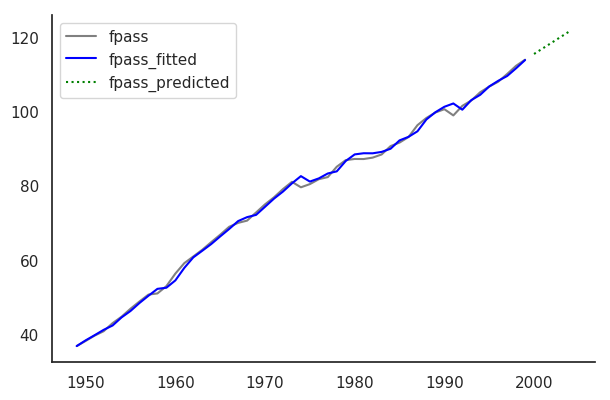

In [15]:
# plot results for fpass: original, fitted and predicted
df[['fpass', 'fpass_fitted', 'fpass_predicted']].plot(
    color=['grey', 'blue', 'green'],
    style=['-','-',':'],
)
sns.despine();

In [16]:
# calculate real passenger numbers
df['passengers_fitted'] = df['fpass_fitted'] ** 4.0
df['passengers_predicted'] = df['fpass_predicted'] ** 4.0
df['passengers_residual'] = df['passengers'] - df['passengers_fitted']

In [17]:
# show current dataframe
df.tail(10)

,passengers,fpass,fpass_fitted,fpass_resid,fpass_predicted,passengers_fitted,passengers_predicted,passengers_residual
1995,129586056.000,106.694,106.717,-0.024,nan,129700734.428,nan,-114678.428
1996,135997845.000,107.990,108.236,-0.246,nan,137241676.494,nan,-1243831.494
1997,146822932.000,110.077,109.532,0.546,nan,143933778.077,nan,2889153.923
1998,158996788.000,112.292,111.620,0.672,nan,155224655.856,nan,3772132.144
1999,168477753.000,113.929,113.834,0.096,nan,167912062.810,nan,565690.190
2000,nan,nan,nan,nan,115.471,nan,177786089.771,nan
2001,nan,nan,nan,nan,117.013,nan,187474912.699,nan
2002,nan,nan,nan,nan,118.555,nan,197554451.642,nan
2003,nan,nan,nan,nan,120.098,nan,208035072.165,nan
2004,nan,nan,nan,nan,121.640,nan,218927275.543,nan


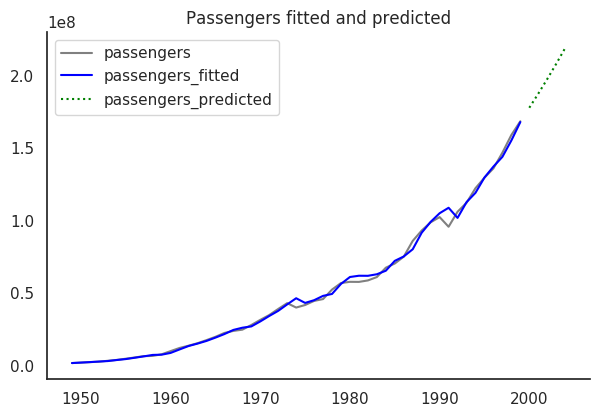

In [18]:
# plot results for real passenger numbers: original, fitted and predicted
df[['passengers', 'passengers_fitted', 'passengers_predicted']].plot(
    color=['grey', 'blue', 'green'],
    style=['-','-',':'],
    title='Passengers fitted and predicted'
)
sns.despine();

In [19]:
# calculate the real passengers RMSE: 2.8 million
SSE_passengers = np.sum(df['passengers_residual'] ** 2)
RMSE_passengers = np.sqrt(SSE_passengers / (len(df.loc[:1999])-2)) # 2 paramters = 2 degrees of freedom
print('SSE_passengers: {}\nRMSE_passengers: {}'.format(SSE_passengers, RMSE_passengers))

SSE_passengers: 387034210538212.9
RMSE_passengers: 2810455.009055066


# The rest of the notebook is just checking out the residuals of the real passenger numbers

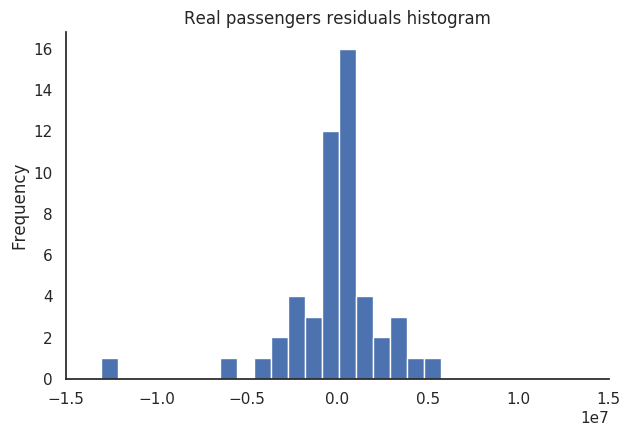

In [20]:
# plot the real passengers residuals
ax = df['passengers_residual'].plot(
    kind='hist',
    title='Real passengers residuals histogram',
    bins=20
)
ax.set(xlim=[-1.5e7,1.5e7])
sns.despine();

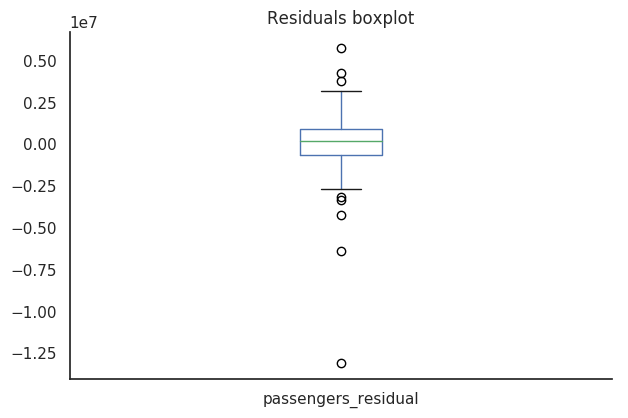

In [21]:
# plotting residuals in a boxplot
df['passengers_residual'].plot(kind='box', title='Residuals boxplot')
sns.despine();

In [22]:
# largest negative error
df['passengers_residual'].nsmallest(3).sort_values()

1991   -13083326.655
1974    -6413514.310
1981    -4248184.119
Name: passengers_residual, dtype: float64

In [23]:
# largest positive error
df['passengers_residual'].nlargest(3).sort_values(ascending=False)

1987   5756672.820
1992   4240530.814
1998   3772132.144
Name: passengers_residual, dtype: float64

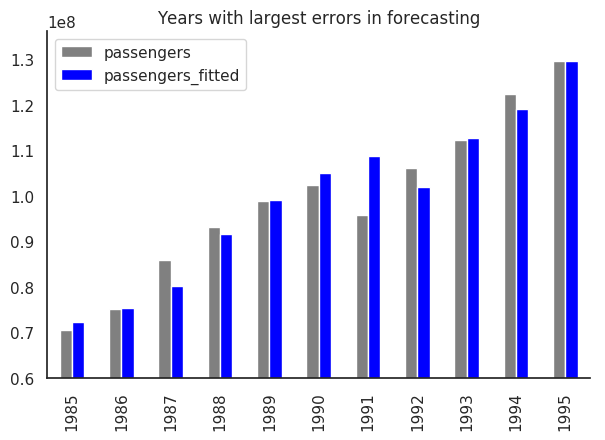

In [24]:
# inspect years with highest fitting errors: 1987 and 1991
# it happens when there's an deviation from the pattern before
# for example a sudden uplift in passengers or a sudden downfall of passenger numbers
ax = df[['passengers', 'passengers_fitted']].loc[1985:1995].plot(
    color=['grey', 'blue'],
    title='Years with largest errors in forecasting',
    kind='bar'
)
ax.set(ylim=(6e7))
sns.despine();

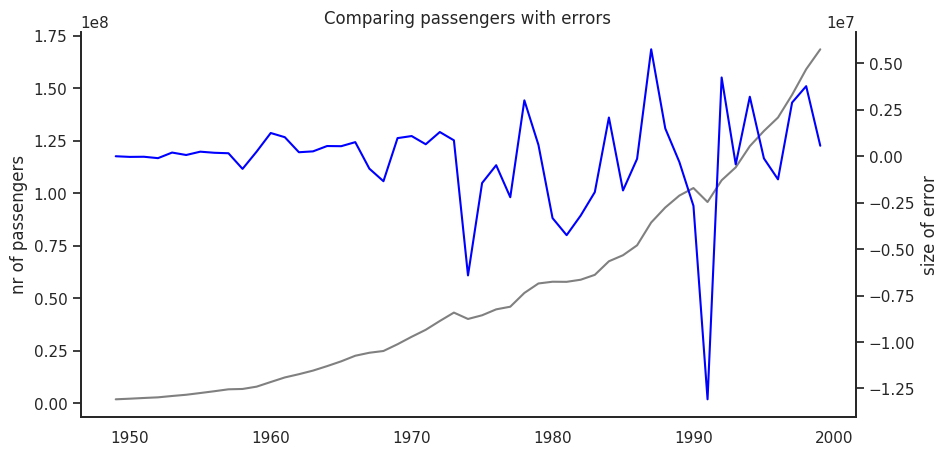

In [25]:
# comparing passengers with errors using a secondary y-axis
ax = df['passengers'].loc[1949:1999].plot(
    color='grey', 
    kind='line', 
    figsize=(10,5), 
    title='Comparing passengers with errors'
)
ax.set(ylabel='nr of passengers')
ax = df['passengers_residual'].loc[1949:1999].plot(secondary_y=True, kind='line', color='blue')
ax.set(ylabel='size of error')
sns.despine(right=False);